In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Importing dependencies

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
from numpy import array
import string
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout
# from keras_preprocessing import load_img, img_to_arr
from tensorflow.keras.optimizers import Adam 
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras_preprocessing import image
from keras.models import Model,load_model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras_preprocessing. sequence import pad_sequences

###Loading the captions dataset

In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
 
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping
 
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
 

def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 

def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
# filename = '/content/drive/MyDrive/flickr/Flickr8k.token.txt'
# doc = load_doc(filename)
# descriptions = load_descriptions(doc)
# print('Loaded: %d ' % len(descriptions))
# clean_descriptions(descriptions)
# vocabulary = to_vocabulary(descriptions)
# print('Vocabulary Size: %d' % len(vocabulary))
# # save to file
# save_descriptions(descriptions, 'descriptions.txt')

###Preparing training captions

In [ ]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [ ]:
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

In [ ]:
filename = '/content/drive/MyDrive/flickr/Flickr_8k.trainImages.txt'
train = load_set(filename)

In [ ]:
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/flickr/descriptions.txt', train)

###Storing training descriptions in database

In [ ]:
database = sqlite3.connect('/content/db')

In [ ]:
cursor = database.cursor()

In [ ]:
cursor.execute("create table train_descriptions(id string,caption1 string,caption2 string,caption3 string,caption4 string,caption5 string)")

In [ ]:
for x,y in train_descriptions.items():
  cursor.execute("Insert into train_descriptions(id,caption1,caption2,caption3,caption4,caption5) values('{}','{}','{}','{}','{}','{}')".format(x,y[0],y[1],y[2],y[3],y[4]))

###Extacting Feature vectors form images

In [ ]:
images = '/content/drive/MyDrive/flickr/Images'
img = glob.glob(images + '*?.jpg')

In [ ]:
def preprocess(image_path):
    # Converting all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Converting PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Adding one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocessing the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 0s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def encode(image):
    image = preprocess(image) # preprocessing the image
    fea_vec = model_new.predict(image) # Geting the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshaping from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/MyDrive/flickr/Flickr_8k.trainImages.txt'
# Reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Creating a list of all the training images with their full path names

train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Checking if the image belongs to training set
        train_img.append(i) # Adding it to the list of train images

In [ ]:
test_images_file = '/content/drive/MyDrive/flickr/Flickr_8k.testImages.txt'
# Reading the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Creating a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Checking if the image belongs to test set
        test_img.append(i) # Adding it to the list of test images

In [ ]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 0.0001323223114013672


In [ ]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 0.0001697540283203125


In [ ]:
pickle.dump(encoding_train, open("encoded_train_images.pkl", "wb"))
pickle.dump(encoding_test,open("encoded_test_images.pkl", "wb"))

In [ ]:
train_features = load(open("/content/drive/MyDrive/flickr/encoded_train_images.pkl", "rb"))

###Creating Word Corpus from train descriptions

In [ ]:
cursor.execute("SELECT * FROM train_descriptions ")

In [ ]:
record = cursor.fetchall()
print("SQLite Database Version is: ", record)

SQLite Database Version is:  [('1000268201_693b08cb0e', 'startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq'), ('1001773457_577c3a7d70', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq'), ('1002674143_1b742ab4b8', 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rain

In [ ]:
all_train_captions = []
rs = cursor.execute("select * from train_descriptions")
for r in rs:
  for i in range(1,6):
    all_train_captions.append(r[i])
len(all_train_captions)  

30000

In [ ]:
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2530


###Tokenizing words

In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2531

In [ ]:
pickle.dump(wordtoix, open("wordtoix.pkl", "wb"))
pickle.dump(ixtoword, open("ixtoword.pkl", "wb"))

In [ ]:
embeddings_index = {} # empty dictionary
f = open('/content/drive/MyDrive/flickr/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Geting 200-dim dense vector for each of the 1652 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
pickle.dump(embedding_matrix, open("embedding_matrix.pkl", "wb"))

### Defining model

In [ ]:
max_length = max(len(d.split()) for d in all_train_captions)

Description Length: 34


In [ ]:
inputs1 = Input(shape=(2048,)) # feature vector
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,)) # word sequence
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      1515800     ['input_4[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['input_3[0][0]']                
                                                                                              

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer = 'adam')

###Training Model

In [ ]:
epochs = 15
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    # X- INPUT y - OUTPUR
    X1, X2, y = list(), list(), list()
    n=0
    # looping for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieving the photo feature
            photo = photos[key+'.jpg']  # feature vector
            for desc in desc_list:
                # encoding the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # spliting one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # spliting into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pading input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encoding output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # storing
                    X1.append(photo)  # feature vector
                    X2.append(in_seq) # padded input sequence
                    y.append(out_seq) # encoded output sequence
            # yielding the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/flickr/model_weights/weight' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 1087s 544ms/step - loss: 2.4523


###Making predictions with test set 



In [ ]:
model = load_model('/content/drive/MyDrive/flickr/model_weights/weight14.h5')

In [ ]:
with open("/content/drive/MyDrive/flickr/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
encoding_test['106490881_5a2dd9b7bd.jpg']

array([0.4193285 , 0.19502951, 0.11467575, ..., 0.3960293 , 1.372138  ,
       0.24658509], dtype=float32)

In [ ]:
images = '/content/drive/MyDrive/flickr/Images'
z = 0

In [ ]:
max_length=34
wordtoix = pickle.load(open('/content/wordtoix.pkl','rb'))
ixtoword = pickle.load(open('/content/ixtoword.pkl','rb'))
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

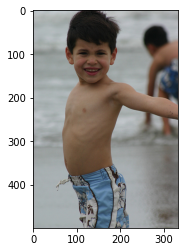

Greedy: boy in swimming trunks is playing in the water


In [ ]:
z=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

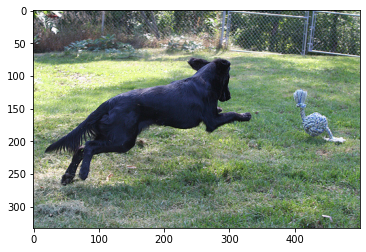

Greedy: black dog is running through the grass


In [ ]:
z+=4
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

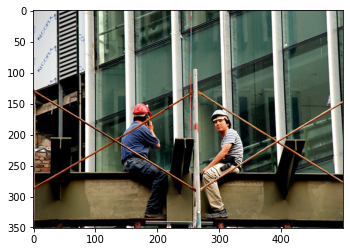

Greedy: man in red shirt is walking on railroad tracks


In [ ]:
z=35
pic = list(train_features.keys())[z]
image = train_features[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

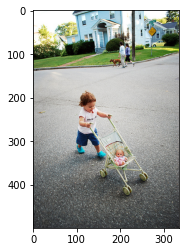

Greedy: little boy in red shirt is walking along the street


In [ ]:
z+=10
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

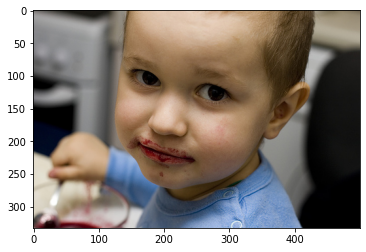

Greedy: baby in white shirt is eating piece of water


In [ ]:
z+=90
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

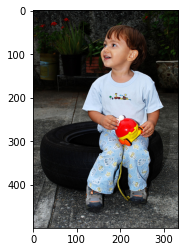

Greedy: young boy in pink shirt is playing with toy


In [ ]:
z+=180
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

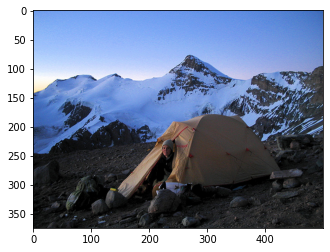

Greedy: man in red shirt is standing on the edge of rock


In [ ]:
z+=100
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

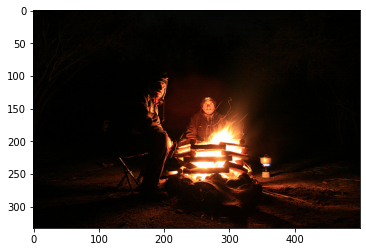

Greedy: man in black uniform is sitting on bus


In [ ]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

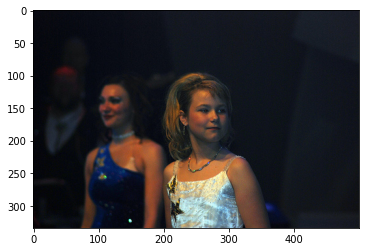

Greedy: woman in pink tank top and black pants is standing in front of crowd


In [ ]:
z-=100
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

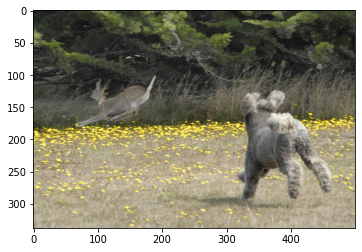

Greedy: white dog is running through the grass


In [ ]:
z+=2
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

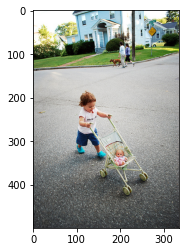

Greedy: little boy in red shirt is walking along the street


In [ ]:
z=45
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

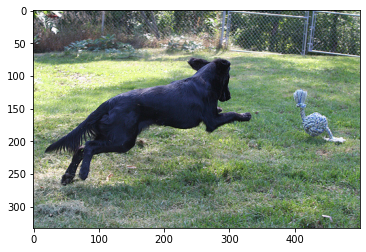

Greedy: black dog is running through the grass


In [ ]:
z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+"/"+pic)
plt.imshow(x)
plt.show()
final = greedySearch(image)
print("Greedy:",final)

###Evalution of model

In [ ]:
def evaluate_model(model, descriptions, photos):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
            s=key + ".jpg"
            photos[s] = photos[s].reshape((1,2048))
            yhat = greedySearch(photos[s])
            # store actual and predicted
            references = [d.split()[1:-1] for d in desc_list]
            actual.append(references)
            predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
filename = '/content/drive/MyDrive/flickr/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)

Dataset: 1001


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
evaluate_model(model,test_descriptions,encoding_test)

BLEU-1: 0.446928
BLEU-2: 0.255683
BLEU-3: 0.180201
BLEU-4: 0.084947
